In [1]:
# pip install tsad

In [2]:
# pip install shap

# Pipeline for the anomaly detection on the SKAB using Isolation forest



In [6]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
from io import StringIO
import requests
from tsad.evaluating.evaluating import evaluating
import numpy as np
from sklearn.ensemble import IsolationForest
import shap

# Data loading

In [33]:
def dataframe_expirement(i):
    if i == 1:
        url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
        df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
        df = df[df[df.columns[0]] == 'xxxAA684G'] #xxxAA684G

        df.replace(['-9999', -9999,'missing','#'], np.nan, inplace=True)
        df = df[df['unitless'].notna()]
        df = df[df['uR/h'].notna()]
        df = df[df['ohmm'].notna()]
        df = df.drop(axis=1, labels=(df.columns[0])) \
            .drop(axis=1, labels=(df.columns[1]))[['uR/h', 'unitless','ohmm']].reset_index(drop=True)
        return df
    else:
        url = "https://storage.yandexcloud.net/cloud-files-public/noname_ECG_2022.csv" 
        dataframe_edited_ = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep=',')
        return dataframe_edited_

In [34]:
ts_data_1, ts_data_2 = dataframe_expirement(1), dataframe_expirement(0).iloc[2500:].reset_index().drop(labels='index',axis=1)

# Data description and visualization

In [35]:
from scipy.signal import find_peaks

In [36]:
def plot_data_scores_and_selected_window(ts, score_list, window_size_selected):
    f, ax = plt.subplots(2, 1, figsize=(30, 20))
    ax[0].plot(ts)
    ax[0].vlines(x=window_size_selected, ymin=min(ts), ymax=max(ts),
        linestyle = ':',
        linewidth = 6,
        color = 'darkblue')
    ax[0].set_title("ts")
    ax[1].plot(score_list, "r")
    ax[1].set_title("score")
    f.show()

In [37]:
# dataset characteristics printing
print(f'A number of datasets: {2}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
print(f'Shape of the medical dataset: {ts_data_2.shape}\n')
cp_1 = []
temp_value_second = 0
for i in range(len(ts_data_1)):
    temp_value = ts_data_1['unitless'][i]
    if temp_value != temp_value_second:
        cp_1.append(1)
    else:
        cp_1.append(0)
    temp_value_second = temp_value
cp_1[0] = 0
cp_2 = []
peaks, _ = find_peaks(ts_data_2['EcgWaveform'], distance=250)
for i in range(len(ts_data_2)):
    if i not in peaks:
        cp_2.append(0)
    else:
        cp_2.append(1)
ts_data_1['change_points'] = cp_1
ts_data_2['change_points'] = cp_2
print(f'A number of datasets: {2}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
print(f'Shape of the medical dataset: {ts_data_2.shape}\n')
n_cp_1 = cp_1.count(1)
n_cp_2 = cp_2.count(1)
print(f'A number of changepoints in the well dataset: {n_cp_1}\n')
print(f'A number of changepoints in the medical dataset: {n_cp_2}\n')
print(f'Head of the well dataset:')
display(ts_data_1.head())
print(f'Head of the well dataset:')
display(ts_data_2.head())

A number of datasets: 2

Shape of the well dataset: (10661, 3)

Shape of the medical dataset: (17500, 2)

A number of datasets: 2

Shape of the well dataset: (10661, 4)

Shape of the medical dataset: (17500, 3)

A number of changepoints in the well dataset: 74

A number of changepoints in the medical dataset: 37

Head of the well dataset:


,uR/h,unitless,ohmm,change_points
0,109.590,2.0,12.200000,0
1,110.990,2.0,11.017710,0
2,112.390,2.0,9.950000,0
3,112.895,2.0,9.223475,0
4,113.400,2.0,8.550000,0


Head of the well dataset:


,Time,EcgWaveform,change_points
0,04/08/2022 08:38:37.946,2450,0
1,04/08/2022 08:38:37.947,2447,0
2,04/08/2022 08:38:37.948,2445,0
3,04/08/2022 08:38:37.949,2442,0
4,04/08/2022 08:38:37.950,2440,0


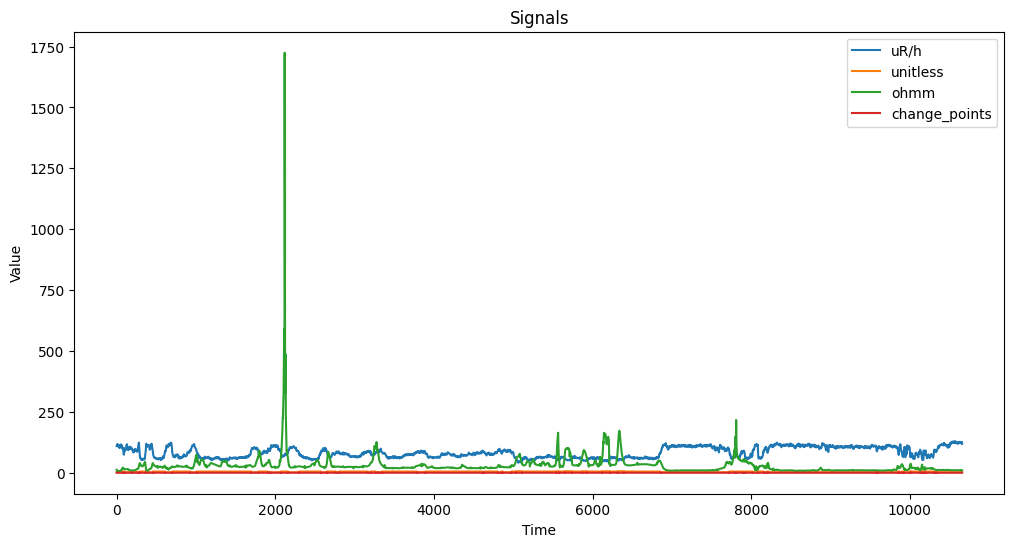

In [38]:
# well dataset visualizing
ts_data_1.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

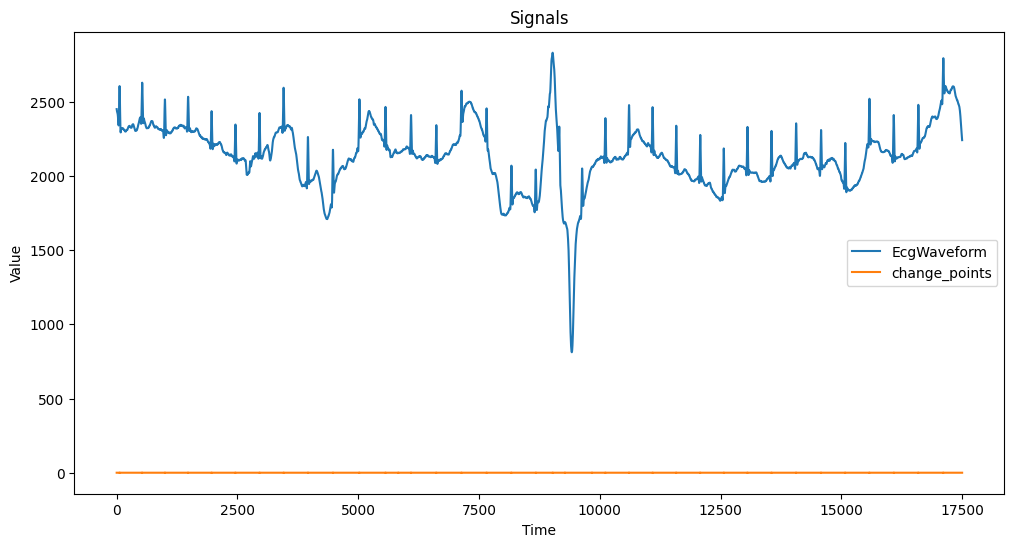

In [39]:
# medical dataset visualizing
ts_data_2.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

In [40]:

list_of_df = [ts_data_1[['change_points','uR/h','ohmm']], ts_data_2.drop('Time', axis=1)]

# Method applying

In [41]:
# classifier initializing
clf = IsolationForest(random_state=0, 
                      n_jobs=-1,
                      contamination=0.01)

In [42]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['change_points'], axis=1)
    
    # classifier fitting
    clf.fit(X_train)

    # results predicting
    prediction = pd.Series(clf.predict(df.drop(['change_points'], axis=1))*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

X does not have valid feature names, but IsolationForest was fitted with feature names
X does not have valid feature names, but IsolationForest was fitted with feature names


# Results

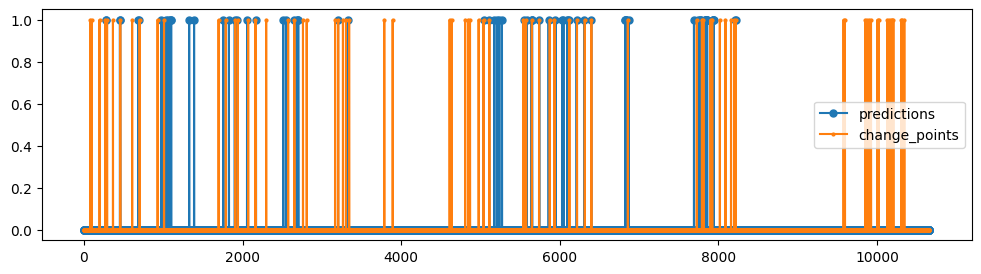

In [43]:
# true changepoint indices selection
true_cp = [df.change_points for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

# Metrics calculation

In [54]:
def tsad_average(predicted_list, original_list):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(original_list, predicted_list, metric='average_time', numenta_time='30 sec', verbose=False)
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    if precision == 0 or recall ==0:
        F1 = 0
    else:
        F1 = 2*precision*recall/(precision+recall)
    return {'Time_Delta': averate_time, 'Missed_CP': missed_cp, 'FPs': FPs, 'True_Anomalies_Count': true_anomalies, 'precision':precision, 'recall':recall,'F1':F1}

def tsad_nab(predicted_list, original_list):
    nab = evaluating(original_list, predicted_list, metric='nab', numenta_time='30 sec', verbose=False)
    return nab

In [44]:
from datetime import datetime, timedelta

In [45]:
true_cp = [df.change_points for df in list_of_df]

In [46]:
t_0 = np.arange(len(true_cp[0])).astype('datetime64[s]')
t_1 = np.arange(len(true_cp[1])).astype('datetime64[s]')

In [47]:
df_0 = pd.DataFrame(index=t_0, columns=['predicted_cp'])
df_0['predicted_cp'] = np.array(predicted_cp[0])
df_0['true_cp'] = np.array(true_cp[0])

In [48]:
df_1 = pd.DataFrame(index=t_1, columns=['predicted_cp'])
df_1['predicted_cp'] = np.array(predicted_cp[1])
df_1['true_cp'] = np.array(true_cp[1])

In [49]:
# nab metric calculation
nab = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='nab', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('1970-01-01 00:01:22'), Timestamp('1970-01-01 00:01:07'))
Intersection of scoring windows(Timestamp('1970-01-01 00:04:28'), Timestamp('1970-01-01 00:04:21'))
Intersection of scoring windows(Timestamp('1970-01-01 01:16:50'), Timestamp('1970-01-01 01:16:45'))
Intersection of scoring windows(Timestamp('1970-01-01 01:20:48'), Timestamp('1970-01-01 01:20:37'))
Intersection of scoring windows(Timestamp('1970-01-01 02:09:51'), Timestamp('1970-01-01 02:09:40'))
Intersection of scoring windows(Timestamp('1970-01-01 02:11:40'), Timestamp('1970-01-01 02:11:31'))
Intersection of scoring windows(Timestamp('1970-01-01 02:16:38'), Timestamp('1970-01-01 02:16:26'))
Intersection of scoring windows(Timestamp('1970-01-01 02:39:37'), Timestamp('1970-01-01 02:39:24'))
Intersection of scoring windows(Timestamp('1970-01-01 02:44:11'), Timestamp('1970-01-01 02:43:57'))
Intersection of scoring windows(Timestamp('1970-01-01 02:45:00'), Timestamp('1970-01-01 02:44:53'))


In [50]:
# average detection delay metric calculation
add = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='average_time', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('1970-01-01 00:01:22'), Timestamp('1970-01-01 00:01:07'))
Intersection of scoring windows(Timestamp('1970-01-01 00:04:28'), Timestamp('1970-01-01 00:04:21'))
Intersection of scoring windows(Timestamp('1970-01-01 01:16:50'), Timestamp('1970-01-01 01:16:45'))
Intersection of scoring windows(Timestamp('1970-01-01 01:20:48'), Timestamp('1970-01-01 01:20:37'))
Intersection of scoring windows(Timestamp('1970-01-01 02:09:51'), Timestamp('1970-01-01 02:09:40'))
Intersection of scoring windows(Timestamp('1970-01-01 02:11:40'), Timestamp('1970-01-01 02:11:31'))
Intersection of scoring windows(Timestamp('1970-01-01 02:16:38'), Timestamp('1970-01-01 02:16:26'))
Intersection of scoring windows(Timestamp('1970-01-01 02:39:37'), Timestamp('1970-01-01 02:39:24'))
Intersection of scoring windows(Timestamp('1970-01-01 02:44:11'), Timestamp('1970-01-01 02:43:57'))
Intersection of scoring windows(Timestamp('1970-01-01 02:45:00'), Timestamp('1970-01-01 02:44:53'))


In [51]:
# nab metric calculation
nab = evaluating(df_1['true_cp'], df_1['predicted_cp'], metric='nab', numenta_time='30 sec')

Standart  -  2.51
LowFP  -  0.48
LowFN  -  4.37


In [52]:
# average detection delay metric calculation
add = evaluating(df_1['true_cp'], df_1['predicted_cp'], metric='average_time', numenta_time='30 sec')

Amount of true anomalies 37
A number of missed CPs = 34
A number of FPs = 11
Average time 0 days 00:00:04.666666666


In [55]:
# TP = 52 - 36
# FPS = 62
# FPN = 36
# precision = TP/(FPS+TP)
# recall = TP/(FPN + TP)
# F1 = 2*precision*recall/(precision+recall)
# print(F1)
# print(precision)
# print(recall)

In [56]:
def create_report(experiment_results: dict):
    experiment_df = pd.DataFrame.from_dict(experiment_results, orient='index')
    experiment_df = experiment_df.fillna(0)
    return experiment_df

In [57]:
%%capture --no-display
tsad_average_results = tsad_average(df_0['true_cp'], df_0['predicted_cp'])

In [58]:
%%capture --no-display
tsad_nab_results = tsad_nab(df_0['true_cp'], df_0['predicted_cp'])

In [59]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,12.07
LowFP,7.27
LowFN,15.94
Time_Delta,0 days 00:00:11.555555555
Missed_CP,58
FPs,56
True_Anomalies_Count,76
precision,0.243243
recall,0.236842
F1,0.24
